In [44]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets
import numpy as np
from scipy import interpolate


# cat = Table.read("FlightPrincipalCatalog_v5_tronc.csv")#
# cat = Table.read("/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/Flight/dobc_data/180922/CosmicRayFree/HeaderCatalog.csv")#
cat = Table.read("/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/Flight/dobc_data/180922/CosmicRayFree/HeaderCatalogbasic_estimators_FIREBall.csv")#


# for c in cat.colnames:
#     cat.rename_column(c,c.replace(" ","_").split("[")[0])
cat = cat.to_pandas()
x="IMNO"
# x = "SECONDS_TU"
# x = "Mins_after_launch"

# for col in ["EMGAIN","N_CR","EXPTIME"]:
#     cat[col.lower()] = interpolate.interp1d(cat[x][cat["IMNO"]>1], cat[col][cat["IMNO"]>1], kind="nearest",fill_value="extrapolate")(cat[x])


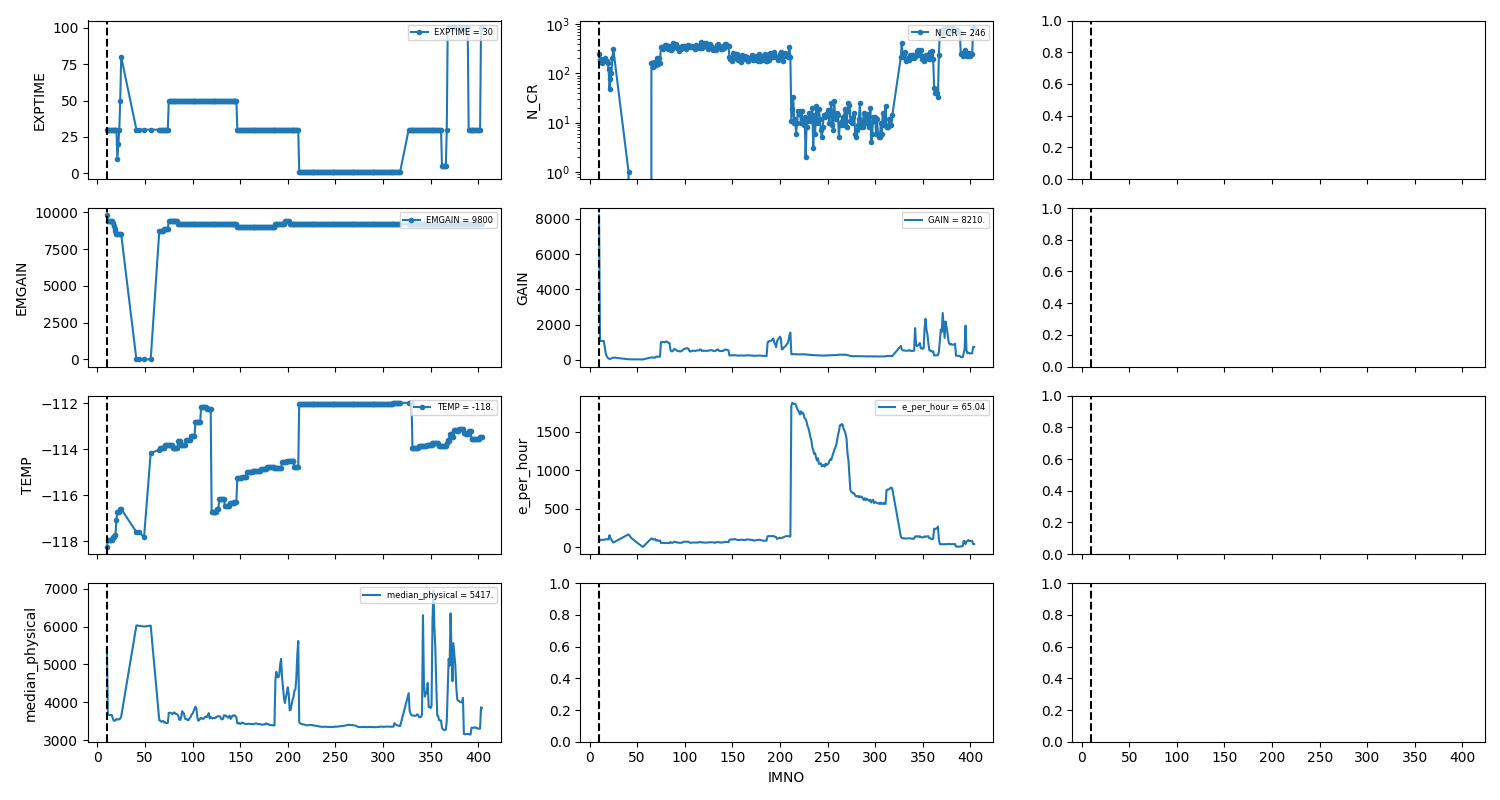

In [49]:
def add_line(cat, y, ax, i=0, x=x, init=True,l=None,style='.-',display=True, change=False, ylabel=None,log=False,ylim=None, **kwargs):
    if ylabel is None:
        ylabel = y
    if display == False:
        label = None
    else:
        try:
            label = ylabel.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
        except KeyError as e:
            label = None#ylabel
    # print(label)
    if init:
        if log:
            if display==False: 
                l = ax.semilogy(cat.eval(x),cat.eval(y),'none', **kwargs)
            else:
                l = ax.semilogy(cat.eval(x),cat.eval(y),style, **kwargs)
        else:
            if display==False: 
                l = ax.plot(cat.eval(x),cat.eval(y),'none', **kwargs)
            else:
                l = ax.plot(cat.eval(x),cat.eval(y),style, **kwargs)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)      
    if change:
        l[0].set_data(cat.eval(x),cat.eval(y))
        if display==False:
            l[0].set_linestyle('none')
        else:
            l[0].set_linestyle(style.replace(".","").replace("o",""))
    l[0].set_label(label)
    if label is not None:
        ax.legend(loc="upper right", fontsize=6)
    return l


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True


# Bruits
# 1. RN
# 2. CIC
# 3. dark? / sky
# 4. gain / gain sans smearing
# 5. smearing
# Temperatures:
# 1. CR/t (avec % image lost)
# 2. temperatures
# Parametre
# 1. DAQ
# 2. Exptime
# 3. Readout sequence?
# Reduction:
# 1. Flux dans les fentes
# 2. stack?


# from datetime import datetime
# plt.figure()
# plt.plot([datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["DATE"]],cat["IMNO"])
# plt.gcf().autofmt_xdate()
# plt.show()

# median_physical mean_physical Col2ColDiff_pre_scan n_pre_scan mean_pre_scan std_pre_scan staXY
# stdXY_Bottom stdXY_pre_scan Bottomimade TopImage _ron hist_gai e_per_hour

class dashboard(widgets.HBox):
     
    def __init__(self,cat=cat,x=x,st=".-"):
        super().__init__()
        self.output = widgets.Output()
        
        # self.ax1bis = self.ax1.twinx()

        self.fig, self.axes = plt.subplots(4,3, figsize=(15,8),sharex=True)
        self.cat=cat
        # (self.a0,self.a1,self.a2,self.a3) = self.axes
        a0, a1, a2, a3 = self.axes
        a3[1].set_xlabel(x)
        # a0[1].sharex(a0[0])
        # a0[0].get_shared_x_axes().join(a0[0],a0[1])
        self.la000 =  add_line(cat,"EXPTIME",ax=a0[0],style=st,display=True)
        self.la010 =  add_line(cat,"EMGAIN",ax=a1[0],style=st,display=True)
        self.la100 = add_line(cat,"N_CR",ax=a0[1],style=st,display=True,log=True)
        self.la200 = add_line(cat,"TEMP",ax=a2[0],style=st,display=True)

        self.la30 = add_line(cat,"median_physical",ax=a3[0],style='-',display=True)#,ylabel="median_physical")
        # self.la310 = add_line(cat,y="n_cr[n_cr<2000]/exptime[n_cr<2000]",ax=a3[1],x="Mins_after_launch[n_cr<2000]",style='-',display=True,ylabel="CR/texp")
        self.la21 = add_line(cat,y="e_per_hour",ax=a2[1],style='-',display=True)#,ylabel="texp")
        self.la11 = add_line(cat,y="hist_gain",ax=a1[1],style='-',display=True,ylabel="GAIN")
        # self.la320 = add_line(cat,y="LINAENC",ax=a3[2],style='-',display=True)
        # self.la321 = add_line(cat,y="LINBENC",ax=a3[2],style='-',display=True)
        # self.la322 = add_line(cat,y="LINCENC",ax=a3[2],style='-',display=True,ylabel="LIN ENC")
        # self.la020 = add_line(cat,"AZ",ax=a0[2],style='-',display=True)
        # self.la021 = add_line(cat,"Moon_Az",ax=a0[2],style='-',display=True)
        # self.la022 = add_line(cat,"Sun_Az",ax=a0[2],style='-',display=True)
        # self.la023 = add_line(cat,"F2_Az",ax=a0[2],style='-',display=True)
        # self.la024 = add_line(cat,"m31_Az",ax=a0[2],style='-',display=True, ylabel="Azimuth")
        # self.la120 = add_line(cat,"EL",ax=a1[2],style='-',display=True)
        # self.la121 = add_line(cat,"Moon_El",ax=a1[2],style='-',display=True)
        # self.la122 = add_line(cat,"Sun_El",ax=a1[2],style='-',display=True)
        # self.la123 = add_line(cat,"F2_El",ax=a1[2],style='-',display=True)
        # self.la124 = add_line(cat,"m31_El",ax=a1[2],style='-',display=True, ylabel="Elevation")
        # self.la22 = add_line(cat,"MROT",ax=a2[2],style='-',display=True)

        self.vlines = []
        for axes in self.axes:
            for ax in axes:
                line = ax.axvline(x=cat[x][0], color="black", ls='--')
                self.vlines.append(line)

        self.fig.tight_layout()


        self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
        self.temps = widgets.SelectMultiple(options=["TEMP", 'TEMPA', 'TEMPB'],value=["TEMP"],rows=3,description='Temps',disabled=False)
        self.x =  widgets.Dropdown(options=["IMNO", "DATE"],value="IMNO",description='x axis',disabled=False)
        self.y =  widgets.Dropdown(options=["value", "value/exptime"],value="value",description='y axis',disabled=False)
        # self.style=widgets.Dropdown(options=['-', '--o', '-.', ':', 'None', ' ', ''],value="-",rows=1,description='style',disabled=False)
        # self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
        # self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
        # self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
        wids = widgets.interactive(self.update,t=self.t,temps=self.temps,x=self.x,y=self.y)#,style=self.style)#,targets=self.targets,xlim=self.xlim,GS=self.GS)
        controls = VBox([HBox([self.t,self.temps, self.x, self.y])] ) #,self.targets,self.xlim,self.GS #,self.style
        display(HBox([self.output,controls]))

        


    def update(self,t,temps,x,y,style="-" ): #,targets,xlim,GS
        """Draw line in plot"""


        with self.output:
            a0, a1, a2, a3 = self.axes



        # self.vlines = []
            for line in  self.vlines:
                line.set_xdata(self.cat[x][t])
            # if xlim == "all":
            #     for a in a0:
            #         a.set_xlim((np.nanmin(cat[x]),np.nanmax(cat[x])))
            # elif xlim=="flight":
            #     for a in a0:
            #         a.set_xlim((50,150))
            # elif xlim=="F2":
            #     for a in a0:
            #         a.set_xlim((600,680))
            # elif xlim== "UV":
            #     for a in a0:
            #         a.set_xlim((500,850))
            add_line(cat,"EXPTIME",ax=a0[0],i=t, init=False,l= self.la000 ,style=style,display=True ,change=True)
            add_line(cat,"EMGAIN",ax=a1[0],i=t, init=False,l= self.la010 ,style=style,display=True,change=True)
            add_line(cat,"N_CR",ax=a0[1],i=t, init=False, l=self.la100,style=style,display=True, change=True)

            add_line(cat,"TEMP",ax=a2[0],i=t, init=False,l= self.la200,style=style,display=True, change=True)
            # add_line(cat,"Reject",ax=a2[0],i=t, init=False, l=self.la201,style='-',display=True if "Reject" in temps else False,change=True)
            # add_line(cat,"Coldhead",ax=a2[0],i=t, init=False, l=self.la202,style='-',display=True if "Coldhead" in temps else False, change=True)
            a2[0].relim()
            a2[0].autoscale_view()

            add_line(cat,"median_physical",ax=a3[0],i=t,init=False,l=self.la30,style='-',display=True)#,ylabel="Altitude")
            # add_line(cat,"n_cr/exptime",ax=a3[1],i=t, init=False, l=self.la310,style='-',display=True)
            add_line(cat,"e_per_hour",ax=a2[1],i=t, init=False, l=self.la21,style='-',display=True)
            add_line(cat,"hist_gain",ax=a1[1],i=t, init=False, l=self.la11,style='-',display=True)
            # add_line(cat,"LINAENC",ax=a3[2],i=t, init=False, l=self.la320,style='-',display=True)
            # add_line(cat,"LINBENC",ax=a3[2],i=t, init=False, l=self.la321,style='-',display=True)
            # add_line(cat,"LINCENC",ax=a3[2],i=t, init=False, l=self.la322,style='-',display=True)
            # add_line(cat,"AZ",ax=a0[2],i=t, init=False, l=self.la020,style='-',display=True,)
            # add_line(cat,"Moon_Az",ax=a0[2],i=t, init=False, l=self.la021,style='-',display=True if "Moon" in targets else False, change=True)
            # add_line(cat,"Sun_Az",ax=a0[2],i=t, init=False, l=self.la022,style='-',display=True if "Sun" in targets else False, change=True)
            # add_line(cat,"F2_Az",ax=a0[2],i=t, init=False, l=self.la023,style='-',display=True if "F2" in targets else False, change=True)
            # add_line(cat,"m31_Az",ax=a0[2],i=t, init=False, l=self.la024,style='-',display=True if "m31" in targets else False, change=True)
            a0[2].relim()
            a0[2].autoscale_view()

            # add_line(cat,"EL",ax=a1[2],i=t, init=False, l=self.la120,style='-',display=True)
            # add_line(cat,"Moon_El",ax=a1[2],i=t, init=False, l=self.la121,style='-',display=True if "Moon" in targets else False, change=True)
            # add_line(cat,"Sun_El",ax=a1[2],i=t, init=False, l=self.la122,style='-',display=True if "Sun" in targets else False, change=True)
            # add_line(cat,"F2_El",ax=a1[2],i=t, init=False, l=self.la123,style='-',display=True if "F2" in targets else False, change=True)
            # add_line(cat,"m31_El",ax=a1[2],i=t, init=False, l=self.la124,style='-',display=True if "m31" in targets else False, change=True)
            a0[2].relim()
            a0[2].autoscale_view()
            # add_line(cat,"MROT",ax=a2[2],i=t, init=False, l=self.la22, style='-',display=True)
            self.fig.canvas.draw()
            self.axes = a0, a1, a2, a3 
            return 
            # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))

d = dashboard(cat)
# add log for GS Flux

Todo:
- put all orders (temperatures, az/el, guiding stars positions)
- add electric consumption?
- add new temperatures
- change to dates x abs
- add some tracer with t
- add BRD-VM_30MS_1-TM-MISSION1-Batterie